In [1]:
import pickle
import gzip
import numpy as np
import scipy
import pandas as pd
import keras
import keras.layers as layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.layers import Input, LSTM, Dense, Lambda, Conv1D, Conv2D, AveragePooling2D, AveragePooling1D, Flatten, MaxPooling2D, MaxPooling1D, Dropout
from keras.models import Model
from keras.models import Sequential
from keras.utils import Sequence
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop
from keras.applications import imagenet_utils
from keras import backend as K
from time import time
from keras import losses
from sklearn.metrics import  roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score, mean_absolute_error
import glob
from PIL import Image
import h5py
import random
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.gaussian_process as gp
import pandas as pd
import pickle
from joblib import dump, load
from sklearn.utils import shuffle
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install silence_tensorflow

  Created wheel for silence-tensorflow: filename=silence_tensorflow-1.1.1-cp36-none-any.whl size=3743 sha256=db5218ecca5711be23bc8ae7c6a29cddc37a3d4e1f804b04090f834f43fe7496
  Stored in directory: /root/.cache/pip/wheels/51/0b/35/cf3020764bee61daa81fa249df3a448e3806344a087fc12292
Successfully built silence-tensorflow


In [4]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Dec 23 18:17:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !rm -R qmc qmc1
    !git clone https://github.com/fagonzalezo/qmc.git
    !mv qmc qmc1
    !mv qmc1/qmc .
else:
    import sys
    sys.path.insert(0, "../")

rm: cannot remove 'qmc': No such file or directory
rm: cannot remove 'qmc1': No such file or directory
Cloning into 'qmc'...
remote: Enumerating objects: 215, done.
remote: Total 215 (delta 0), reused 0 (delta 0), pack-reused 215
Receiving objects: 100% (215/215), 17.06 MiB | 5.06 MiB/s, done.
Resolving deltas: 100% (91/91), done.


In [8]:
import qmc.tf.layers as layers
import qmc.tf.models as models

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Colab_Notebooks/ICML2021/pyrimidines/data/pyrim_train_5.1', header = None, sep = ' ')
X = data.to_numpy()
y = X[:,-1]
X = X[:,0:-1]

In [ ]:
X.shape

(50, 27)

In [ ]:
y.shape

(50,)

Los labels van de 1 a 5

In [ ]:
print(max(y))
print(min(y))

[1.]
[0.]


In [ ]:
y = (y-1)/4
y = np.float64(y)
y = y.reshape((50,1))
X = np.float64(X)

Normalizando los datos:

In [ ]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [ ]:
from scipy.spatial import distance

distances = distance.cdist(X, X, 'euclidean')

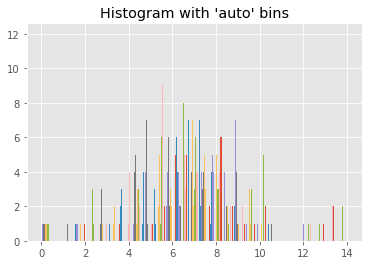

In [ ]:
import matplotlib.pyplot as plt

_ = plt.hist(distances, bins='auto')  # arguments are passed to np.histogram

plt.title("Histogram with 'auto' bins")

plt.show()

Sigma:

In [ ]:
print(np.mean(distances))
print(np.median(distances))

6.796587951595358
6.828117509217618


Gamma:

In [ ]:
print(1/(np.mean(distances)**2))
print(1/(np.median(distances)**2))

0.02164801685724408
0.021448554409531456


In [10]:
BIG_MAE=[]
for i in range(20):
    print('----------------------------------------',i+1)
    number = str(i+1)
    train_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/pyrimidines/data/pyrim_train_5.'
    test_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/pyrimidines/data/pyrim_test_5.'
    
    data = pd.read_csv(train_path+number, header = None, sep = ' ')
    X = data.to_numpy()
    y = X[:,-1]
    X = X[:,0:-1]

    y = (y-1)/4
    y = np.float64(y)
    y = y.reshape((50,1))
    X = np.float64(X)

    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)

    MAE_opt = 100
    dim_y = 5
    
    beta_opt = 15.940399383393302 
    gamma_opt = 0.0042998656819813776 
    learning_rate_opt = 0.000540869643114694 
    alpha_opt = 0.17782494595318865 
    dim_x_opt = 256 
    num_eig_opt = 8

    X_train = X
    y_train = y

    X_test = pd.read_csv(test_path+number, header = None, sep = ' ')
    X_test = X_test.to_numpy()
    X_test = np.float64(X_test)
    y_test = X_test[:,-1]
    X_test = X_test[:,0:-1]
    X_test = scaler.transform(X_test)
    y_test = (y_test-1)/4
    y_test = np.float64(y_test)
    y_test = y_test.reshape((24,1))

    fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta_opt)
    fm_x = layers.QFeatureMapRFF(27, dim=dim_x_opt, gamma=gamma_opt, random_state=1)
    qmr2 = models.QMRegressorSGD(input_dim=27, dim_x=dim_x_opt, num_eig=num_eig_opt, dim_y=dim_y, gamma=gamma_opt, random_state=17)

    # for initialize weights

    qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x_opt, dim_y=dim_y)
    qmr.compile()
    qmr.fit(X_train, y_train, epochs=1, batch_size = 4)

    qmr2.set_rho(qmr.get_rho())
    # Train model with SGD
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_opt)
    qmr2.layers[0].trainable = True

    def loss(y_true, y_pred):
        return tf.keras.losses.MAE(y_true, y_pred[:,0:1]) + alpha_opt * y_pred[:, 1:2]

    qmr2.compile(optimizer, loss=loss)
    qmr2.set_rho(qmr.get_rho())
    early_stop = EarlyStopping( monitor="val_loss",
                                min_delta=0,
                                patience=5,
                                verbose=0,
                                mode="auto",
                                restore_best_weights=True,
                                )

    qmr2.fit(X_train, y_train, epochs=100, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose = 0)

    out = qmr2.predict(X_test, batch_size = 4)
    y_pred, std = out[:, 0], np.sqrt(out[:, 1])
    print('------------MAE =', mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))
    BIG_MAE.append(mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))

np.mean(BIG_MAE), np.std(BIG_MAE)

---------------------------------------- 1
13/13 [==============================] - 0s 1ms/step
------------MAE = 0.7916666666666666
---------------------------------------- 2
13/13 [==============================] - 0s 1ms/step
------------MAE = 0.6666666666666666
---------------------------------------- 3
13/13 [==============================] - 0s 2ms/step
------------MAE = 0.75
---------------------------------------- 4
13/13 [==============================] - 0s 1ms/step
------------MAE = 0.375
---------------------------------------- 5
13/13 [==============================] - 0s 2ms/step
------------MAE = 0.8333333333333334
---------------------------------------- 6
13/13 [==============================] - 0s 2ms/step
------------MAE = 0.5
---------------------------------------- 7
13/13 [==============================] - 0s 2ms/step
------------MAE = 0.4583333333333333
---------------------------------------- 8
13/13 [==============================] - 0s 1ms/step
------------MAE

(0.6270833333333334, 0.1403585438558456)

In [11]:
BIG_MAE=[]
for i in range(20):
    print('----------------------------------------',i+1)
    number = str(i+1)
    train_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/pyrimidines/data/pyrim_train_5.'
    test_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/pyrimidines/data/pyrim_test_5.'
    
    data = pd.read_csv(train_path+number, header = None, sep = ' ')
    X = data.to_numpy()
    y = X[:,-1]
    X = X[:,0:-1]

    y = (y-1)/4
    y = np.float64(y)
    y = y.reshape((50,1))
    X = np.float64(X)

    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)

    dim_y = 5
  
    beta_opt= 2.3995638184016537 
    gamma_opt= 0.021519281080621098 
    learning_rate_opt= 0.0004311817704887445 
    alpha_opt= 0.8875061948402702 
    dim_x_opt= 256 
    num_eig_opt= 16


    X_train = X
    y_train = y

    X_test = pd.read_csv(test_path+number, header = None, sep = ' ')
    X_test = X_test.to_numpy()
    X_test = np.float64(X_test)
    y_test = X_test[:,-1]
    X_test = X_test[:,0:-1]
    X_test = scaler.transform(X_test)
    y_test = (y_test-1)/4
    y_test = np.float64(y_test)
    y_test = y_test.reshape((24,1))

    fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta_opt)
    fm_x = layers.QFeatureMapRFF(27, dim=dim_x_opt, gamma=gamma_opt, random_state=1)
    qmr2 = models.QMRegressorSGD(input_dim=27, dim_x=dim_x_opt, num_eig=num_eig_opt, dim_y=dim_y, gamma=gamma_opt, random_state=17)

    # for initialize weights

    qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x_opt, dim_y=dim_y)
    qmr.compile()
    qmr.fit(X_train, y_train, epochs=1, batch_size = 4)

    qmr2.set_rho(qmr.get_rho())
    # Train model with SGD
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_opt)
    qmr2.layers[0].trainable = True

    def loss(y_true, y_pred):
        return tf.keras.losses.MAE(y_true, y_pred[:,0:1]) + alpha_opt * y_pred[:, 1:2]

    qmr2.compile(optimizer, loss=loss)
    qmr2.set_rho(qmr.get_rho())
    early_stop = EarlyStopping( monitor="val_loss",
                                min_delta=0,
                                patience=5,
                                verbose=0,
                                mode="auto",
                                restore_best_weights=True,
                                )

    qmr2.fit(X_train, y_train, epochs=100, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose = 0)

    out = qmr2.predict(X_test, batch_size = 4)
    y_pred, std = out[:, 0], np.sqrt(out[:, 1])
    print('------------MAE =', mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))
    BIG_MAE.append(mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))

np.mean(BIG_MAE), np.std(BIG_MAE)

---------------------------------------- 1
13/13 [==============================] - 0s 1ms/step
------------MAE = 0.7083333333333334
---------------------------------------- 2
13/13 [==============================] - 0s 1ms/step
------------MAE = 0.875
---------------------------------------- 3
13/13 [==============================] - 0s 1ms/step
------------MAE = 0.5416666666666666
---------------------------------------- 4
13/13 [==============================] - 0s 1ms/step
------------MAE = 0.625
---------------------------------------- 5
13/13 [==============================] - 0s 2ms/step
------------MAE = 0.625
---------------------------------------- 6
13/13 [==============================] - 0s 1ms/step
------------MAE = 0.5833333333333334
---------------------------------------- 7
13/13 [==============================] - 0s 1ms/step
------------MAE = 0.5
---------------------------------------- 8
13/13 [==============================] - 0s 2ms/step
------------MAE = 0.5
-----

(0.6145833333333333, 0.10447869931766529)

In [12]:
BIG_MAE=[]
for i in range(20):
    print('----------------------------------------',i+1)
    number = str(i+1)
    train_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/pyrimidines/data/pyrim_train_5.'
    test_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/pyrimidines/data/pyrim_test_5.'
    
    data = pd.read_csv(train_path+number, header = None, sep = ' ')
    X = data.to_numpy()
    y = X[:,-1]
    X = X[:,0:-1]

    y = (y-1)/4
    y = np.float64(y)
    y = y.reshape((50,1))
    X = np.float64(X)

    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)

    MAE_opt = 100
    dim_y = 5
  
    beta_opt= 9.229727940829713 
    gamma_opt= 0.008400455404831522 
    learning_rate_opt= 0.0008172714130458333 
    alpha_opt= 0.27178350840744625 
    dim_x_opt= 256 
    num_eig_opt= 32



    X_train = X
    y_train = y

    X_test = pd.read_csv(test_path+number, header = None, sep = ' ')
    X_test = X_test.to_numpy()
    X_test = np.float64(X_test)
    y_test = X_test[:,-1]
    X_test = X_test[:,0:-1]
    X_test = scaler.transform(X_test)
    y_test = (y_test-1)/4
    y_test = np.float64(y_test)
    y_test = y_test.reshape((24,1))

    fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta_opt)
    fm_x = layers.QFeatureMapRFF(27, dim=dim_x_opt, gamma=gamma_opt, random_state=1)
    qmr2 = models.QMRegressorSGD(input_dim=27, dim_x=dim_x_opt, num_eig=num_eig_opt, dim_y=dim_y, gamma=gamma_opt, random_state=17)

    # for initialize weights

    qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x_opt, dim_y=dim_y)
    qmr.compile()
    qmr.fit(X_train, y_train, epochs=1, batch_size = 4)

    qmr2.set_rho(qmr.get_rho())
    # Train model with SGD
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_opt)
    qmr2.layers[0].trainable = True

    def loss(y_true, y_pred):
        return tf.keras.losses.MAE(y_true, y_pred[:,0:1]) + alpha_opt * y_pred[:, 1:2]

    qmr2.compile(optimizer, loss=loss)
    qmr2.set_rho(qmr.get_rho())
    early_stop = EarlyStopping( monitor="val_loss",
                                min_delta=0,
                                patience=5,
                                verbose=0,
                                mode="auto",
                                restore_best_weights=True,
                                )

    qmr2.fit(X_train, y_train, epochs=100, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose = 0)

    out = qmr2.predict(X_test, batch_size = 4)
    y_pred, std = out[:, 0], np.sqrt(out[:, 1])
    print('------------MAE =', mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))
    BIG_MAE.append(mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))

np.mean(BIG_MAE), np.std(BIG_MAE)

---------------------------------------- 1
13/13 [==============================] - 0s 1ms/step
------------MAE = 0.8333333333333334
---------------------------------------- 2
13/13 [==============================] - 0s 1ms/step
------------MAE = 0.7916666666666666
---------------------------------------- 3
13/13 [==============================] - 0s 1ms/step
------------MAE = 0.625
---------------------------------------- 4
13/13 [==============================] - 0s 1ms/step
------------MAE = 0.5833333333333334
---------------------------------------- 5
13/13 [==============================] - 0s 1ms/step
------------MAE = 0.7083333333333334
---------------------------------------- 6
13/13 [==============================] - 0s 2ms/step
------------MAE = 0.5416666666666666
---------------------------------------- 7
13/13 [==============================] - 0s 1ms/step
------------MAE = 0.375
---------------------------------------- 8
13/13 [==============================] - 0s 1ms/step

(0.5895833333333333, 0.1135560006242637)

In [13]:
BIG_MAE=[]
for i in range(20):
    print('----------------------------------------',i+1)
    number = str(i+1)
    train_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/pyrimidines/data/pyrim_train_5.'
    test_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/pyrimidines/data/pyrim_test_5.'
    
    data = pd.read_csv(train_path+number, header = None, sep = ' ')
    X = data.to_numpy()
    y = X[:,-1]
    X = X[:,0:-1]

    y = (y-1)/4
    y = np.float64(y)
    y = y.reshape((50,1))
    X = np.float64(X)

    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)

    MAE_opt = 100
    dim_y = 5
  
    beta_opt= 17.336524470308955 
    gamma_opt= 0.0204081 
    learning_rate_opt= 0.0009326892724334732 
    alpha_opt= 0.5328945892837489 
    dim_x_opt= 256 
    num_eig_opt= 16


    X_train = X
    y_train = y

    X_test = pd.read_csv(test_path+number, header = None, sep = ' ')
    X_test = X_test.to_numpy()
    X_test = np.float64(X_test)
    y_test = X_test[:,-1]
    X_test = X_test[:,0:-1]
    X_test = scaler.transform(X_test)
    y_test = (y_test-1)/4
    y_test = np.float64(y_test)
    y_test = y_test.reshape((24,1))

    fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta_opt)
    fm_x = layers.QFeatureMapRFF(27, dim=dim_x_opt, gamma=gamma_opt, random_state=1)
    qmr2 = models.QMRegressorSGD(input_dim=27, dim_x=dim_x_opt, num_eig=num_eig_opt, dim_y=dim_y, gamma=gamma_opt, random_state=17)

    # for initialize weights

    qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x_opt, dim_y=dim_y)
    qmr.compile()
    qmr.fit(X_train, y_train, epochs=1, batch_size = 4)

    qmr2.set_rho(qmr.get_rho())
    # Train model with SGD
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_opt)
    qmr2.layers[0].trainable = True

    def loss(y_true, y_pred):
        return tf.keras.losses.MAE(y_true, y_pred[:,0:1]) + alpha_opt * y_pred[:, 1:2]

    qmr2.compile(optimizer, loss=loss)
    qmr2.set_rho(qmr.get_rho())
    early_stop = EarlyStopping( monitor="val_loss",
                                min_delta=0,
                                patience=5,
                                verbose=0,
                                mode="auto",
                                restore_best_weights=True,
                                )

    qmr2.fit(X_train, y_train, epochs=100, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose = 0)

    out = qmr2.predict(X_test, batch_size = 4)
    y_pred, std = out[:, 0], np.sqrt(out[:, 1])
    print('------------MAE =', mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))
    BIG_MAE.append(mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))

np.mean(BIG_MAE), np.std(BIG_MAE)

---------------------------------------- 1
13/13 [==============================] - 0s 1ms/step
------------MAE = 0.7916666666666666
---------------------------------------- 2
13/13 [==============================] - 0s 1ms/step
------------MAE = 0.75
---------------------------------------- 3
13/13 [==============================] - 0s 1ms/step
------------MAE = 0.625
---------------------------------------- 4
13/13 [==============================] - 0s 1ms/step
------------MAE = 0.5
---------------------------------------- 5
13/13 [==============================] - 0s 1ms/step
------------MAE = 0.6666666666666666
---------------------------------------- 6
13/13 [==============================] - 0s 1ms/step
------------MAE = 0.5
---------------------------------------- 7
13/13 [==============================] - 0s 1ms/step
------------MAE = 0.375
---------------------------------------- 8
13/13 [==============================] - 0s 1ms/step
------------MAE = 0.5
---------------------

(0.5708333333333333, 0.11031835245728105)

In [14]:
BIG_MAE=[]
for i in range(20):
    print('----------------------------------------',i+1)
    number = str(i+1)
    train_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/pyrimidines/data/pyrim_train_5.'
    test_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/pyrimidines/data/pyrim_test_5.'
    
    data = pd.read_csv(train_path+number, header = None, sep = ' ')
    X = data.to_numpy()
    y = X[:,-1]
    X = X[:,0:-1]

    y = (y-1)/4
    y = np.float64(y)
    y = y.reshape((50,1))
    X = np.float64(X)

    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)

    MAE_opt = 100
    dim_y = 5
  
    beta_opt= 4.6578276399357 
    gamma_opt= 0.021519281080621098 
    learning_rate_opt= 0.0005595708271322344 
    alpha_opt= 0.01404351332392817 
    dim_x_opt= 256 
    num_eig_opt= 8


    X_train = X
    y_train = y

    X_test = pd.read_csv(test_path+number, header = None, sep = ' ')
    X_test = X_test.to_numpy()
    X_test = np.float64(X_test)
    y_test = X_test[:,-1]
    X_test = X_test[:,0:-1]
    X_test = scaler.transform(X_test)
    y_test = (y_test-1)/4
    y_test = np.float64(y_test)
    y_test = y_test.reshape((24,1))

    fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta_opt)
    fm_x = layers.QFeatureMapRFF(27, dim=dim_x_opt, gamma=gamma_opt, random_state=1)
    qmr2 = models.QMRegressorSGD(input_dim=27, dim_x=dim_x_opt, num_eig=num_eig_opt, dim_y=dim_y, gamma=gamma_opt, random_state=17)

    # for initialize weights

    qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x_opt, dim_y=dim_y)
    qmr.compile()
    qmr.fit(X_train, y_train, epochs=1, batch_size = 4)

    qmr2.set_rho(qmr.get_rho())
    # Train model with SGD
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_opt)
    qmr2.layers[0].trainable = True

    def loss(y_true, y_pred):
        return tf.keras.losses.MAE(y_true, y_pred[:,0:1]) + alpha_opt * y_pred[:, 1:2]

    qmr2.compile(optimizer, loss=loss)
    qmr2.set_rho(qmr.get_rho())
    early_stop = EarlyStopping( monitor="val_loss",
                                min_delta=0,
                                patience=5,
                                verbose=0,
                                mode="auto",
                                restore_best_weights=True,
                                )

    qmr2.fit(X_train, y_train, epochs=100, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose = 0)

    out = qmr2.predict(X_test, batch_size = 4)
    y_pred, std = out[:, 0], np.sqrt(out[:, 1])
    print('------------MAE =', mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))
    BIG_MAE.append(mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))

np.mean(BIG_MAE), np.std(BIG_MAE)

---------------------------------------- 1
13/13 [==============================] - 0s 2ms/step
------------MAE = 0.75
---------------------------------------- 2
13/13 [==============================] - 0s 2ms/step
------------MAE = 0.8333333333333334
---------------------------------------- 3
13/13 [==============================] - 0s 1ms/step
------------MAE = 0.5833333333333334
---------------------------------------- 4
13/13 [==============================] - 0s 2ms/step
------------MAE = 0.625
---------------------------------------- 5
13/13 [==============================] - 0s 2ms/step
------------MAE = 0.4583333333333333
---------------------------------------- 6
13/13 [==============================] - 0s 2ms/step
------------MAE = 0.5833333333333334
---------------------------------------- 7
13/13 [==============================] - 0s 1ms/step
------------MAE = 0.5833333333333334
---------------------------------------- 8
13/13 [==============================] - 0s 1ms/step


(0.6229166666666667, 0.12806994074419736)

In [15]:
BIG_MAE=[]
for i in range(20):
    print('----------------------------------------',i+1)
    number = str(i+1)
    train_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/pyrimidines/data/pyrim_train_5.'
    test_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/pyrimidines/data/pyrim_test_5.'
    
    data = pd.read_csv(train_path+number, header = None, sep = ' ')
    X = data.to_numpy()
    y = X[:,-1]
    X = X[:,0:-1]

    y = (y-1)/4
    y = np.float64(y)
    y = y.reshape((50,1))
    X = np.float64(X)

    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)

    MAE_opt = 100
    dim_y = 5
  
    beta_opt= 20.006927133234978 
    gamma_opt= 0.007865615206445258 
    learning_rate_opt= 0.0006245787854783899 
    alpha_opt= 0.025364686267407066 
    dim_x_opt= 1024 
    num_eig_opt= 64


    X_train = X
    y_train = y

    X_test = pd.read_csv(test_path+number, header = None, sep = ' ')
    X_test = X_test.to_numpy()
    X_test = np.float64(X_test)
    y_test = X_test[:,-1]
    X_test = X_test[:,0:-1]
    X_test = scaler.transform(X_test)
    y_test = (y_test-1)/4
    y_test = np.float64(y_test)
    y_test = y_test.reshape((24,1))

    fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta_opt)
    fm_x = layers.QFeatureMapRFF(27, dim=dim_x_opt, gamma=gamma_opt, random_state=1)
    qmr2 = models.QMRegressorSGD(input_dim=27, dim_x=dim_x_opt, num_eig=num_eig_opt, dim_y=dim_y, gamma=gamma_opt, random_state=17)

    # for initialize weights

    qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x_opt, dim_y=dim_y)
    qmr.compile()
    qmr.fit(X_train, y_train, epochs=1, batch_size = 4)

    qmr2.set_rho(qmr.get_rho())
    # Train model with SGD
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_opt)
    qmr2.layers[0].trainable = True

    def loss(y_true, y_pred):
        return tf.keras.losses.MAE(y_true, y_pred[:,0:1]) + alpha_opt * y_pred[:, 1:2]

    qmr2.compile(optimizer, loss=loss)
    qmr2.set_rho(qmr.get_rho())
    early_stop = EarlyStopping( monitor="val_loss",
                                min_delta=0,
                                patience=5,
                                verbose=0,
                                mode="auto",
                                restore_best_weights=True,
                                )

    qmr2.fit(X_train, y_train, epochs=100, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose = 0)

    out = qmr2.predict(X_test, batch_size = 4)
    y_pred, std = out[:, 0], np.sqrt(out[:, 1])
    print('------------MAE =', mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))
    BIG_MAE.append(mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))

np.mean(BIG_MAE), np.std(BIG_MAE)

---------------------------------------- 1
13/13 [==============================] - 0s 2ms/step
------------MAE = 0.5833333333333334
---------------------------------------- 2
13/13 [==============================] - 0s 2ms/step
------------MAE = 1.0416666666666667
---------------------------------------- 3
13/13 [==============================] - 0s 2ms/step
------------MAE = 0.5833333333333334
---------------------------------------- 4
13/13 [==============================] - 0s 2ms/step
------------MAE = 0.5833333333333334
---------------------------------------- 5
13/13 [==============================] - 0s 2ms/step
------------MAE = 0.5833333333333334
---------------------------------------- 6
13/13 [==============================] - 0s 2ms/step
------------MAE = 0.5
---------------------------------------- 7
13/13 [==============================] - 0s 2ms/step
------------MAE = 0.4583333333333333
---------------------------------------- 8
13/13 [==============================] - 

(0.5895833333333333, 0.14510233457804872)

In [16]:
BIG_MAE=[]
for i in range(20):
    print('----------------------------------------',i+1)
    number = str(i+1)
    train_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/pyrimidines/data/pyrim_train_5.'
    test_path = '/content/drive/My Drive/Colab_Notebooks/ICML2021/pyrimidines/data/pyrim_test_5.'
    
    data = pd.read_csv(train_path+number, header = None, sep = ' ')
    X = data.to_numpy()
    y = X[:,-1]
    X = X[:,0:-1]

    y = (y-1)/4
    y = np.float64(y)
    y = y.reshape((50,1))
    X = np.float64(X)

    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)

    MAE_opt = 100
    dim_y = 5
  
  
    beta_opt= 6.802880768697603 
    gamma_opt= 0.006364247209820296 
    learning_rate_opt= 0.00026943110890087653 
    alpha_opt= 0.008332512810219628 
    dim_x_opt= 1024 
    num_eig_opt= 128

    X_train = X
    y_train = y

    X_test = pd.read_csv(test_path+number, header = None, sep = ' ')
    X_test = X_test.to_numpy()
    X_test = np.float64(X_test)
    y_test = X_test[:,-1]
    X_test = X_test[:,0:-1]
    X_test = scaler.transform(X_test)
    y_test = (y_test-1)/4
    y_test = np.float64(y_test)
    y_test = y_test.reshape((24,1))

    fm_y = layers.QFeatureMapSmp(dim=dim_y, beta=beta_opt)
    fm_x = layers.QFeatureMapRFF(27, dim=dim_x_opt, gamma=gamma_opt, random_state=1)
    qmr2 = models.QMRegressorSGD(input_dim=27, dim_x=dim_x_opt, num_eig=num_eig_opt, dim_y=dim_y, gamma=gamma_opt, random_state=17)

    # for initialize weights

    qmr = models.QMRegressor(fm_x=fm_x, fm_y=fm_y, dim_x=dim_x_opt, dim_y=dim_y)
    qmr.compile()
    qmr.fit(X_train, y_train, epochs=1, batch_size = 4)

    qmr2.set_rho(qmr.get_rho())
    # Train model with SGD
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_opt)
    qmr2.layers[0].trainable = True

    def loss(y_true, y_pred):
        return tf.keras.losses.MAE(y_true, y_pred[:,0:1]) + alpha_opt * y_pred[:, 1:2]

    qmr2.compile(optimizer, loss=loss)
    qmr2.set_rho(qmr.get_rho())
    early_stop = EarlyStopping( monitor="val_loss",
                                min_delta=0,
                                patience=5,
                                verbose=0,
                                mode="auto",
                                restore_best_weights=True,
                                )

    qmr2.fit(X_train, y_train, epochs=100, validation_split = 0.2, batch_size = 4, callbacks = early_stop, verbose = 0)

    out = qmr2.predict(X_test, batch_size = 4)
    y_pred, std = out[:, 0], np.sqrt(out[:, 1])
    print('------------MAE =', mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))
    BIG_MAE.append(mean_absolute_error(np.rint(y_test*4)+1, np.rint(y_pred*4)+1))

np.mean(BIG_MAE), np.std(BIG_MAE)

---------------------------------------- 1
13/13 [==============================] - 0s 2ms/step
------------MAE = 0.4166666666666667
---------------------------------------- 2
13/13 [==============================] - 0s 2ms/step
------------MAE = 0.875
---------------------------------------- 3
13/13 [==============================] - 0s 2ms/step
------------MAE = 0.4583333333333333
---------------------------------------- 4
13/13 [==============================] - 0s 2ms/step
------------MAE = 0.375
---------------------------------------- 5
13/13 [==============================] - 0s 2ms/step
------------MAE = 0.875
---------------------------------------- 6
13/13 [==============================] - 0s 2ms/step
------------MAE = 0.4583333333333333
---------------------------------------- 7
13/13 [==============================] - 0s 2ms/step
------------MAE = 0.625
---------------------------------------- 8
13/13 [==============================] - 0s 2ms/step
------------MAE = 0.58333

(0.5770833333333334, 0.1462939155338397)